In [1]:
import netCDF4 as nc
import numpy as np
from numpy.linalg import svd 
import pandas as pd
import scipy.stats as stats
from scipy.io import loadmat 
from datetime import datetime

import cartopy
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
import cmocean

from takeout import monthly_means_annual

import copy

In [2]:
# constant declarations
#lat1 < lat2
lat1 = -20
lat2 = 20

lat_lims = [lat1,lat2]

#assuming all years are independent
yrmax = 39
monmax = 468
critical_t = stats.t.ppf(q=0.975, df=monmax)

#variable files on disk
nino_file = '/home/jakidxav/Desktop/work_hartmann/nino_data/Nino_3-4.mat'
omega_file = '/home/jakidxav/Desktop/work_hartmann/erai_monthly/mergeFiles/w_7917.nc'

jan,feb,mar,apr,may,jun,jul,aug,sep,octo,nov,dec = [],[],[],[],[],[],[],[],[],[],[],[]

mon_list = [jan, feb, mar, apr, may, jun, jul, aug, sep, octo, nov, dec]

corr3_max, corr34_max, corr4_max = [], [], []
reg3_max, reg34_max, reg4_max = [], [], []

lon_list = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 239]

#lon_list_labels = ["180W", "150W", "120W", "90W", "60W", "30W", "0", "30E", "60E", "90E", "120E", "150E", "180E"]
lon_list_labels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5]

shifted_lon_list = [60, 80, 100, 120, 140, 160, 180, 200, 220, 239, 0, 20, 40]
shifted_lon_list_labels = [90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5, 0, 30, 60]
shifted_labels_eastWest = ['90E', '120E', '150E', '180', '150W', '120W', '90W', '60W', '30W', '0', '30E', '60E', '90E']

#ytick_list = [36, 25, 21, 17, 14, 10, 9]
p_tick_list = [0, 1, 5, 8, 12, 16, 28]
p_list = [70, 100, 200, 300, 500, 700, 1000]
z_list = [5, 10, 15, 20, 25]

#for plotting
vmin = -0.06
vmax = 0.065
contours = np.arange(vmin, vmax, 0.005)

colormap = cmocean.cm.balance
colorbar_label = r"$hPa \hspace{1} s^{-1}$"

left_title = '$\omega$ '
left_title_up = '-$\omega$ '
eof_title = 'EOF '

#It is actually omega, but weighted for regions where it is upward(or negative) between x˚S and x˚N.
right_title = '1979-2017'

#axis labels
p_label = 'Pressure (mb)'
z_label = 'Height (km)'

figure_name_eof1_up = 'lon_omegaEOF1_up_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'
figure_name_eof2_up = 'lon_omegaEOF2_up_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'
figure_name_eof3_up = 'lon_omegaEOF3_up_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'

figure_name_eof1_down = 'lon_omegaEOF1_down_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'
figure_name_eof2_down = 'lon_omegaEOF2_down_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'
figure_name_eof3_down = 'lon_omegaEOF3_down_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_AllYears.pdf'

### Data Import

In [3]:
#read in data files
#omega is in hPa NOT Pa
omega_data = nc.Dataset(omega_file)

#process variables
omega = omega_data.variables['w'][:]

lon  = omega_data.variables['longitude'][:]
lat  = omega_data.variables['latitude'][:]
dumb_time = omega_data.variables['time'][:]
p = omega_data.variables['level'][:]

#convert time to more user-friendly format
time = pd.to_datetime(dumb_time, unit='h',
                       origin=pd.Timestamp('1900-01-01'))

#for boolean indexing
latidx = (lat >=lat_lims[0] ) & (lat <=lat_lims[1] )

#only take pressures greater than 10hPa (for plotting purposes)
pidx = p >= 70

#subset new tensors for correct latitude, pressure ranges
omega = omega[:, :, latidx, :]
omega = omega[:, pidx, :, :]

#w: FillValue = -32767.
omega = omega.filled(np.nan)

In [4]:
#create monthly means for normalization
monthly_means = monthly_means_annual(omega, time)

#normalize omega data, subtract monthly means
count = 1
for i in np.arange(1979, 2018):
    for j in np.arange(1, 13):
        month = time[count-1].month - 1
        omega[count-1] = omega[count-1] - monthly_means[month]
        count = count + 1

In [5]:
print(np.shape(omega))

(468, 28, 27, 240)


In [6]:
#copy array for creating mask
mask_up = copy.deepcopy(omega)
mask_down = copy.deepcopy(omega)
#mask_total = copy.deepcopy(omega)

#upward mask: M_up
mask_up[np.where(mask_up > 0)] = np.nan
mask_up[np.where(mask_up < 0)] = 1

#downward mask: M_down
mask_down[np.where(mask_down > 0)] = 1
mask_down[np.where(mask_down < 0)] = np.nan

#MX
mask_var_up = np.multiply(omega, mask_up)
mask_var_down = np.multiply(omega, mask_down)

#create cos(lat) matrix
cos_lat = np.asmatrix(np.cos(np.deg2rad(lat[latidx]))).T
cos_lat_matrix = np.multiply(np.ones((27,240)), cos_lat)
#plt.pcolormesh(np.array(cos_lat_matrix))

#MXcos(lat) = AX
mask_var_coslat_up = np.multiply(mask_var_up, np.array(cos_lat_matrix))
mask_var_coslat_down = np.multiply(mask_var_down, np.array(cos_lat_matrix))

#A_up, A_down
mask_up_coslat = np.multiply(mask_up, np.array(cos_lat_matrix))
mask_down_coslat = np.multiply(mask_down, np.array(cos_lat_matrix))

#integrate (sum) over latitude, leaves lon-height time series
mask_var_nanmean_up = np.nanmean(mask_var_coslat_up, axis=2)
mask_var_nanmean_down = np.nanmean(mask_var_coslat_down, axis=2)

mask_nanmean_up = np.nanmean(mask_up_coslat, axis=2)
mask_nanmean_down = np.nanmean(mask_down_coslat, axis=2)

#divide by total area
total_up = np.divide(mask_var_nanmean_up, mask_nanmean_up)
total_down = np.divide(mask_var_nanmean_down, mask_nanmean_down)

# Need to replace these values with 0 before doing regression
total_up[np.where(np.isnan(total_up))] = 0
total_down[np.where(np.isnan(total_down))] = 0

/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/home/jakidxav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


In [7]:
print(total_up.shape)

(468, 28, 240)


## Steps:
- remove monthly mean
- weight by cos(lat)
- calculate dof from Bretherton et al. (1999): $\frac{N^*}{N} = \frac{1-r(\Delta t)^2}{1+r(\Delta t)^2}$, where $r \Delta (t)$ is the autocorrelation function
- svd to get UEVt
- plot $\Sigma$ spectrum, which is $\sigma_i$, where $\sigma^2_i = \lambda_i n$
- put error bars (confidence limits) on $\Sigma$ spectrum from North et al. criterion: $\Delta \lambda = \lambda \sqrt{\frac{2}{N^*}}$

### Autocorrelation and dof

In [8]:
#autocorrelation of sst for one time lag
aa = np.matmul(np.reshape(total_up[:-1], (467, -1)), np.reshape(total_up[:-1], (467, -1)).T) / (monmax - 1)
ab = np.matmul(np.reshape(total_up[1:], (467, -1)), np.reshape(total_up[1:], (467, -1)).T) / (monmax - 1)
ac = np.divide(ab, aa)
autt = np.nanmean(np.multiply(ac, aa)) / np.nanmean(aa)
dof = (monmax - 1) * (1 - autt*autt) / (1 + autt*autt)

In [9]:
dof

0.03155549787413808

### SVD

In [10]:
u, s, vt = svd(np.reshape(total_up, (468, -1)))
v = vt.T
lamda = s * s / monmax
delta = lamda * np.sqrt(2/dof)

Text(0.5, 0, 'Values 11-30')

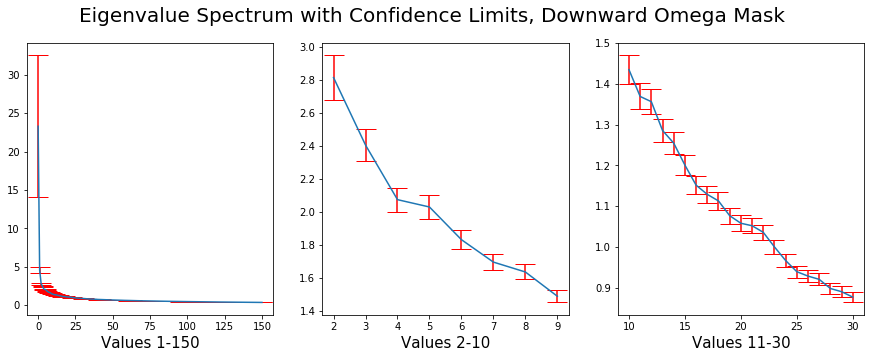

In [11]:
#plot the singular value spectrum with error bars
figure, axis = plt.subplots(1, 3, figsize=(15, 5))
axis[0].errorbar(np.arange(0, 151), s[:151], yerr=delta[:151], ecolor='r', capsize=10)
axis[1].errorbar(np.arange(2, 10), s[2:10], yerr=delta[2:10], ecolor='r', capsize=10)
axis[2].errorbar(np.arange(10, 31), s[10:31], yerr=delta[10:31], ecolor='r', capsize=10)

axis[0].set_title('')
axis[1].set_title('')
axis[2].set_title('')
figure.suptitle('Eigenvalue Spectrum with Confidence Limits, Downward Omega Mask', fontsize=20)
axis[0].set_xlabel('Values 1-150', fontsize=15)
axis[1].set_xlabel('Values 2-10', fontsize=15)
axis[2].set_xlabel('Values 11-30', fontsize=15)
#plt.savefig('eigen_spectrum_downMask.pdf', format='pdf')

In [12]:
eof1 = v[:, 0]
eof2 = v[:, 1]
eof3 = v[:, 2]

eof1_reshape = np.reshape(eof1, (28, 240))
eof2_reshape = np.reshape(eof2, (28, 240))
eof3_reshape = np.reshape(eof3, (28, 240))

print(np.nanmax(eof1))
print(np.nanmin(eof1))
print(np.nanmax(eof2))
print(np.nanmin(eof2))
print(np.nanmax(eof3))
print(np.nanmin(eof3))

0.02278967293465142
0.0002810179606285135
0.0467889935575163
-0.030293185262615232
0.04263352169167104
-0.04283757692647665


In [13]:
#shift array to have Tropics in the middle
zeros = np.zeros((28, 240))
zeros[:, 0:120] = eof1_reshape[:, 60:180]
zeros[:, 120:180] = eof1_reshape[:, 180:240]
zeros[:, 180:240] = eof1_reshape[:, 0:60]

zeros2 = np.zeros((28, 240))
zeros2[:, 0:120] = eof2_reshape[:, 60:180]
zeros2[:, 120:180] = eof2_reshape[:, 180:240]
zeros2[:, 180:240] = eof2_reshape[:, 0:60]

zeros3 = np.zeros((28, 240))
zeros3[:, 0:120] = eof3_reshape[:, 60:180]
zeros3[:, 120:180] = eof3_reshape[:, 180:240]
zeros3[:, 180:240] = eof3_reshape[:, 0:60]

In [14]:
def plot_contours_latHeight(vmin, vmax, field, contours, cmap, cbar_label, left, eof_title, number, right, 
                            p_list, p_label, lon_list, lon_labels, p_tick_list, z_label, figname, savefig):
    fig = plt.figure(figsize=(300, 75))
    fig, ax = plt.subplots()

    Norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    contourf = plt.contourf(field, contours, cmap=cmap, norm=Norm)
    #plt.contour(contourf, colors='black', linewidth=0.5)

    cbar = fig.colorbar(contourf, orientation='horizontal')
    cbar.set_label(cbar_label)
    plt.gca().invert_yaxis()

    ax.set_title(left+eof_title+number, loc='left', weight='semibold', size='medium')
    ax.set_title(right, loc='right', weight='semibold', size='medium')
    ax.set_ylabel(p_label)

    ax.set_xticks(lon_list)
    ax.set_xticklabels(lon_labels)
    ax.set_yticks(p_tick_list)
    ax.set_yticklabels(p_list, fontsize=6)

    ax2 = ax.twinx()
    ax2.set_ylim(20, 0)
    ax2.set_ylabel(z_label)

    plt.gca().invert_yaxis()

    #plt.tight_layout()
    if (savefig == True):
        plt.savefig(figname, format='pdf')
    
    plt.tight_layout()
    plt.show()

<Figure size 21600x5400 with 0 Axes>

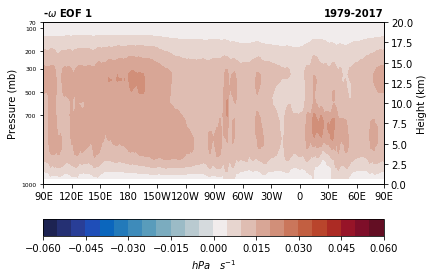

In [15]:
plot_contours_latHeight(vmin, vmax, zeros, contours, colormap, colorbar_label, left_title_up, eof_title, str(1), right_title, p_list, p_label, 
                        lon_list, shifted_labels_eastWest, p_tick_list, z_label, figure_name_eof1_up, False)

<Figure size 21600x5400 with 0 Axes>

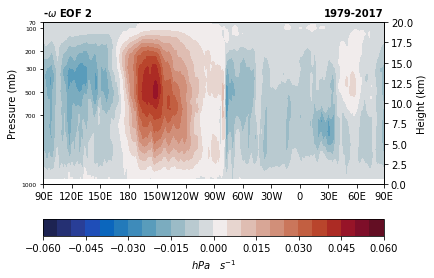

In [16]:
plot_contours_latHeight(vmin, vmax, zeros2, contours, colormap, colorbar_label, left_title_up, eof_title, str(2), right_title, p_list, p_label, 
                        lon_list, shifted_labels_eastWest, p_tick_list, z_label, figure_name_eof2_up, False)

<Figure size 21600x5400 with 0 Axes>

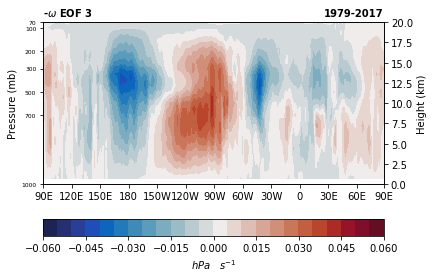

In [17]:
plot_contours_latHeight(vmin, vmax, zeros3, contours, colormap, colorbar_label, left_title_up, eof_title, str(3), right_title, p_list, p_label, 
                        lon_list, shifted_labels_eastWest, p_tick_list, z_label, figure_name_eof3_up, False)